# HW 3 - Analysis of LSTMs for Forecasting Oceanic Patterns

**Author**: Ewan Lister
Completed 05/22/2023

In this notebook we will perform an analysis of the MNIST data set using multiple techniques.

### 1. Download Example code and Data

In [1]:
import numpy as np
from processdata import load_data
from processdata import TimeSeriesDataset
import models
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

num_sensors = 3 
lags = 52
load_X = load_data('SST')
print(np.shape(load_X))
print(load_X)

n = load_X.shape[0]
m = load_X.shape[1]
sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

(1400, 44219)
[[-1.79999996 -1.79999996 -1.79999996 ... -1.30999997 -1.29999997
  -1.26999997]
 [-1.79999996 -1.79999996 -1.79999996 ... -1.31999997 -1.29999997
  -1.26999997]
 [-1.79999996 -1.79999996 -1.79999996 ... -1.16999997 -1.14999997
  -1.10999998]
 ...
 [-1.79999996 -1.79999996 -1.79999996 ... -1.46999997 -1.45999997
  -1.44999997]
 [-1.79999996 -1.79999996 -1.79999996 ... -1.54999997 -1.53999997
  -1.52999997]
 [-1.79999996 -1.79999996 -1.79999996 ... -1.61999996 -1.60999996
  -1.59999996]]


### 2. Train Model and plot results

In [2]:
train_indices = np.random.choice(n - lags, size=1000, replace=False)
mask = np.ones(n - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
valid_indices = valid_test_indices[::2]
test_indices = valid_test_indices[1::2]

In [3]:
sc = MinMaxScaler()
sc = sc.fit(load_X[train_indices])
transformed_X = sc.transform(load_X)

### Generate input sequences to a SHRED model
all_data_in = np.zeros((n - lags, lags, num_sensors))
for i in range(len(all_data_in)):
    all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

### -1 to have output be at the same time as final sensor measurements
train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

In [4]:
shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=150, l2=200, dropout=0.1).to(device)
validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=128, num_epochs=250, lr=1e-3, verbose=True, patience=5)

Training epoch 1
Error tensor(0.8607)
Training epoch 20
Error tensor(0.2680)
Training epoch 40
Error tensor(0.2439)
Training epoch 60
Error tensor(0.2214)
Training epoch 80
Error tensor(0.2185)
Training epoch 100
Error tensor(0.2160)
Training epoch 120
Error tensor(0.2155)
Training epoch 140
Error tensor(0.2157)
Training epoch 160
Error tensor(0.2148)
Training epoch 180
Error tensor(0.2146)
Training epoch 200
Error tensor(0.2130)
Training epoch 220
Error tensor(0.2110)
Training epoch 240
Error tensor(0.2081)


0.0358942


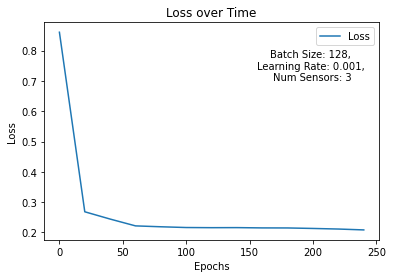

In [22]:
test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
print(np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth))

import matplotlib.pyplot as plt

lr = 1e-3
batch_size = 128
epochs = np.array(range(13)) * 20

# Plotting
plt.plot(epochs, validation_errors, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Time')
plt.legend()

# Creating legend for parameters
legend_text = f'Batch Size: {batch_size}, \nLearning Rate: {lr}, \nNum Sensors: {num_sensors}'
plt.text(0.8, 0.8, legend_text, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

# Display the plot
plt.show()

# plot training progress

### 3. Do an analysis of the performance as a function of the time lag variable

`lags` will be set to 1, 4, 26, 52, and 104 in correspondence to 1 week, 1 month, half a year, a year, and two years

In [24]:
# initialize data 
num_sensors = 3 
lags = [1, 4, 26, 104]

validation_errors_time=[]
for i in range(len(lags)):
    sensor_locations = np.random.choice(m, size=num_sensors, replace=False)
    train_indices = np.random.choice(n - lags[i], size=1000, replace=False)
    mask = np.ones(n - lags[i])
    mask[train_indices] = 0
    valid_test_indices = np.arange(0, n - lags[i])[np.where(mask!=0)[0]]
    valid_indices = valid_test_indices[::2]
    test_indices = valid_test_indices[1::2]

    sc = MinMaxScaler()
    sc = sc.fit(load_X[train_indices])
    transformed_X = sc.transform(load_X)

    ### Generate input sequences to a SHRED model
    all_data_in = np.zeros((n - lags[i], lags[i], num_sensors))
    for j in range(len(all_data_in)):
        all_data_in[i] = transformed_X[j:j+lags[i], sensor_locations]

    ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    ### -1 to have output be at the same time as final sensor measurements
    train_data_out = torch.tensor(transformed_X[train_indices + lags[i] - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags[i] - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags[i] - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=150, l2=200, dropout=0.1).to(device)
    validation_errors_time.append(models.fit(shred, train_dataset, valid_dataset, batch_size=128, num_epochs=250, lr=1e-3, verbose=True, patience=5))




Training epoch 1
Error tensor(0.8700)
Training epoch 20
Error tensor(0.4754)
Training epoch 40
Error tensor(0.4752)
Training epoch 60
Error tensor(0.4755)
Training epoch 80
Error tensor(0.4758)
Training epoch 100
Error tensor(0.4751)
Training epoch 120
Error tensor(0.4751)
Training epoch 140
Error tensor(0.4751)
Training epoch 160
Error tensor(0.4755)
Training epoch 180
Error tensor(0.4756)
Training epoch 200
Error tensor(0.4751)
Training epoch 1
Error tensor(0.8936)
Training epoch 20
Error tensor(0.4695)
Training epoch 40
Error tensor(0.4697)
Training epoch 60
Error tensor(0.4696)
Training epoch 80
Error tensor(0.4697)
Training epoch 100
Error tensor(0.4697)
Training epoch 120
Error tensor(0.4698)
Training epoch 1
Error tensor(0.8583)
Training epoch 20
Error tensor(0.4769)
Training epoch 40
Error tensor(0.4760)
Training epoch 60
Error tensor(0.4760)
Training epoch 80
Error tensor(0.4764)
Training epoch 100
Error tensor(0.4768)
Training epoch 120
Error tensor(0.4757)
Training epoch 140

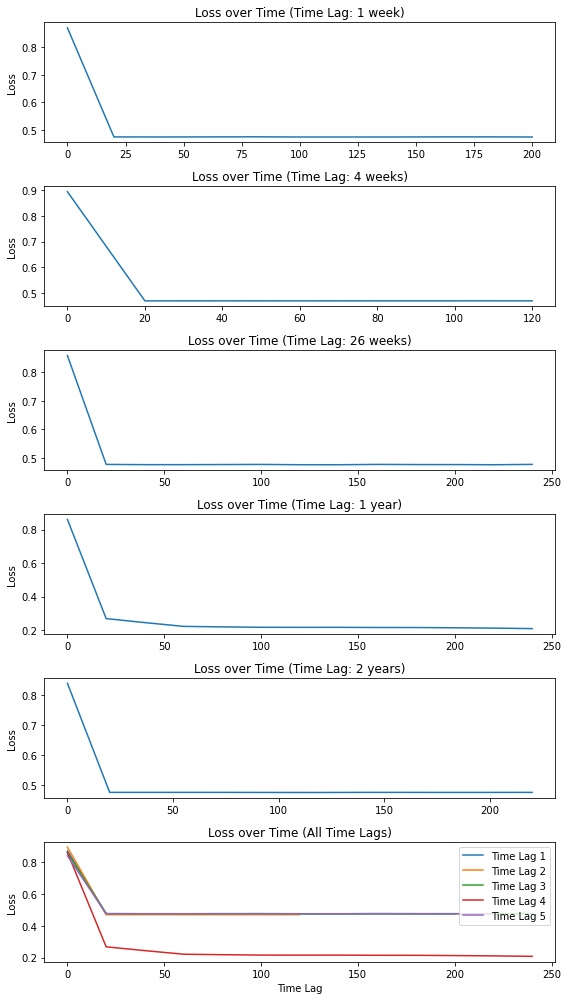

In [29]:
# plot results
# Creating subplots
fig, axs = plt.subplots(6, 1, figsize=(8, 14))
time_lag_values = np.array(range(13)) * 20

# Plotting loss over time for each time lag configuration
axs[0].plot(time_lag_values[0:11], validation_errors_time[0])
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss over Time (Time Lag: 1 week)')

axs[1].plot(time_lag_values[0:7], validation_errors_time[1])
axs[1].set_ylabel('Loss')
axs[1].set_title('Loss over Time (Time Lag: 4 weeks)')

axs[2].plot(time_lag_values[0:13], validation_errors_time[2])
axs[2].set_ylabel('Loss')
axs[2].set_title('Loss over Time (Time Lag: 26 weeks)')

axs[3].plot(time_lag_values, validation_errors)
axs[3].set_ylabel('Loss')
axs[3].set_title('Loss over Time (Time Lag: 1 year)')

axs[4].plot(time_lag_values[0:12], validation_errors_time[3])
axs[4].set_ylabel('Loss')
axs[4].set_title('Loss over Time (Time Lag: 2 years)')

# Plotting all loss values together
axs[5].plot(time_lag_values[0:11], validation_errors_time[0], label='Time Lag 1')
axs[5].plot(time_lag_values[0:7], validation_errors_time[1], label='Time Lag 2')
axs[5].plot(time_lag_values[0:13], validation_errors_time[2], label='Time Lag 3')
axs[5].plot(time_lag_values, validation_errors, label='Time Lag 4')
axs[5].plot(time_lag_values[0:12], validation_errors_time[3], label='Time Lag 5')
axs[5].set_xlabel('Time Lag')
axs[5].set_ylabel('Loss')
axs[5].set_title('Loss over Time (All Time Lags)')
axs[5].legend()

plt.tight_layout()

# Display the subplots
plt.show()



### 4. Do an analysis of the performance as a function of the time lag variable

Gaussian noise will be added to the data, where the standard deviation $\sigma$ of the gaussian is modulated from 0.1 to 0.9 in increments of 0.2.

In [32]:
# initialize data 
num_sensors = 3 
lags = 52
std = [0.1, 0.3, 0.5, 0.7, 0.9]
mean = 0.0

validation_errors_gausse=[]
matrix = np.random.rand(n, m)

for i in range(len(std)):
    sensor_locations = np.random.choice(m, size=num_sensors, replace=False)
    train_indices = np.random.choice(n - lags, size=1000, replace=False)
    mask = np.ones(n - lags)
    mask[train_indices] = 0
    valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
    valid_indices = valid_test_indices[::2]
    test_indices = valid_test_indices[1::2]

    noise = np.random.normal(mean, std[i], size=matrix.shape)

    sc = MinMaxScaler()
    sc = sc.fit(load_X[train_indices])
    transformed_X = sc.transform(load_X)

    ## add noise after scaling
    transformed_X = np.add(transformed_X, noise)

    ### Generate input sequences to a SHRED model
    all_data_in = np.zeros((n - lags, lags, num_sensors))
    for j in range(len(all_data_in)):
        all_data_in[i] = transformed_X[j:j+lags, sensor_locations]

    ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    ### -1 to have output be at the same time as final sensor measurements
    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=100, l2=150, dropout=0.1).to(device)
    validation_errors_time.append(models.fit(shred, train_dataset, valid_dataset, batch_size=128, num_epochs=250, lr=1e-3, verbose=True, patience=5))


Training epoch 1
Error tensor(0.9063)
Training epoch 20
Error tensor(0.5059)
Training epoch 40
Error tensor(0.5063)
Training epoch 60
Error tensor(0.5062)
Training epoch 80
Error tensor(0.5060)
Training epoch 100
Error tensor(0.5068)
Training epoch 120
Error tensor(0.5059)
Training epoch 1
Error tensor(0.9286)
Training epoch 20
Error tensor(0.6634)
Training epoch 40
Error tensor(0.6633)
Training epoch 60
Error tensor(0.6636)
Training epoch 80
Error tensor(0.6633)
Training epoch 100
Error tensor(0.6634)
Training epoch 120
Error tensor(0.6634)
Training epoch 140
Error tensor(0.6634)
Training epoch 160
Error tensor(0.6637)
Training epoch 180
Error tensor(0.6634)
Training epoch 1
Error tensor(0.9503)
Training epoch 20
Error tensor(0.7945)
Training epoch 40
Error tensor(0.7943)
Training epoch 60
Error tensor(0.7944)
Training epoch 80
Error tensor(0.7943)
Training epoch 100
Error tensor(0.7943)
Training epoch 120
Error tensor(0.7943)
Training epoch 140
Error tensor(0.7943)
Training epoch 1
E

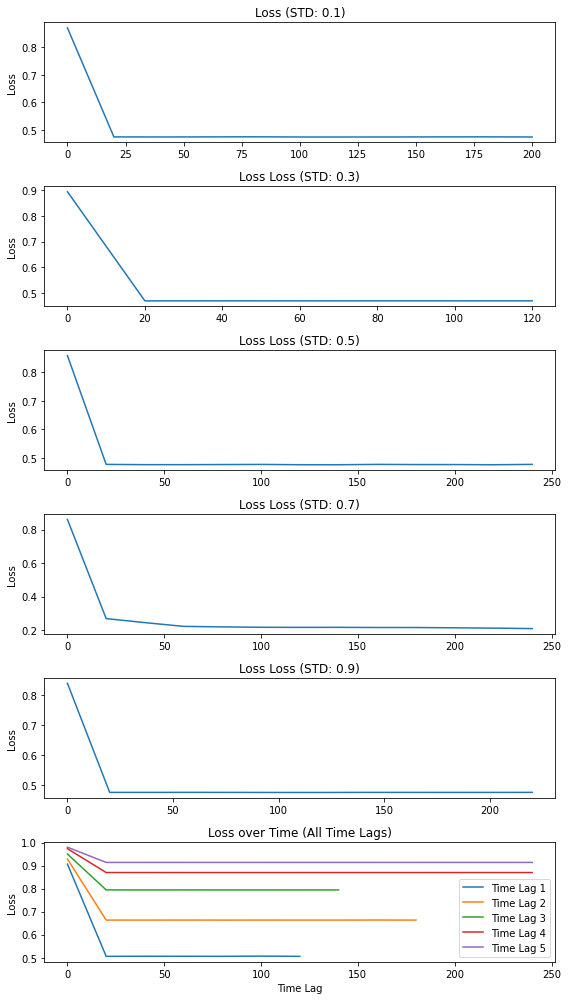

In [38]:
# plot results
# Creating subplots
fig, axs = plt.subplots(6, 1, figsize=(8, 14))
time_lag_values = np.array(range(13)) * 20

# Plotting loss over time for each time lag configuration
axs[0].plot(time_lag_values[0:11], validation_errors_time[0])
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss (STD: 0.1)')

axs[1].plot(time_lag_values[0:7], validation_errors_time[1])
axs[1].set_ylabel('Loss')
axs[1].set_title('Loss Loss (STD: 0.3)')

axs[2].plot(time_lag_values[0:13], validation_errors_time[2])
axs[2].set_ylabel('Loss')
axs[2].set_title('Loss Loss (STD: 0.5)')

axs[3].plot(time_lag_values, validation_errors)
axs[3].set_ylabel('Loss')
axs[3].set_title('Loss Loss (STD: 0.7)')

axs[4].plot(time_lag_values[0:12], validation_errors_time[3])
axs[4].set_ylabel('Loss')
axs[4].set_title('Loss Loss (STD: 0.9)')

# Plotting all loss values together
axs[5].plot(time_lag_values[0:7], validation_errors_time[4], label='Time Lag 1')
axs[5].plot(time_lag_values[0:10], validation_errors_time[5], label='Time Lag 2')
axs[5].plot(time_lag_values[0:8], validation_errors_time[6], label='Time Lag 3')
axs[5].plot(time_lag_values, validation_errors_time[7], label='Time Lag 4')
axs[5].plot(time_lag_values[0:13], validation_errors_time[8], label='Time Lag 5')
axs[5].set_xlabel('Time Lag')
axs[5].set_ylabel('Loss')
axs[5].set_title('Loss over Time (All Time Lags)')
axs[5].legend()

plt.tight_layout()

# Display the subplots
plt.show()

### 5. Do an analysis of the performance as a function of the number of sensors

In [41]:
# initialize data 
num_sensors = [1, 5, 7, 9] 
lags = 52
validation_errors_sensors = []

for i in range(len(num_sensors)):
    sensor_locations = np.random.choice(m, size=num_sensors[i], replace=False)
    train_indices = np.random.choice(n - lags, size=1000, replace=False)
    mask = np.ones(n - lags)
    mask[train_indices] = 0
    valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
    valid_indices = valid_test_indices[::2]
    test_indices = valid_test_indices[1::2]

    sc = MinMaxScaler()
    sc = sc.fit(load_X[train_indices])
    transformed_X = sc.transform(load_X)

    ### Generate input sequences to a SHRED model
    all_data_in = np.zeros((n - lags, lags, num_sensors[i]))
    for j in range(len(all_data_in)):
        all_data_in[i] = transformed_X[j:j+lags, sensor_locations]

    ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    ### -1 to have output be at the same time as final sensor measurements
    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

    shred = models.SHRED(num_sensors[i], m, hidden_size=32, hidden_layers=2, l1=100, l2=150, dropout=0.1).to(device)
    validation_errors_sensors.append(models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=40, lr=1e-3, verbose=True, patience=5))


Training epoch 1
Error tensor(0.6198)
Training epoch 20
Error tensor(0.4668)
Training epoch 40
Error tensor(0.4659)
Training epoch 1
Error tensor(0.6589)
Training epoch 20
Error tensor(0.4728)
Training epoch 40
Error tensor(0.4730)
Training epoch 1
Error tensor(0.6464)
Training epoch 20
Error tensor(0.4705)
Training epoch 40
Error tensor(0.4710)
Training epoch 1
Error tensor(0.6280)
Training epoch 20
Error tensor(0.4718)
Training epoch 40
Error tensor(0.4714)


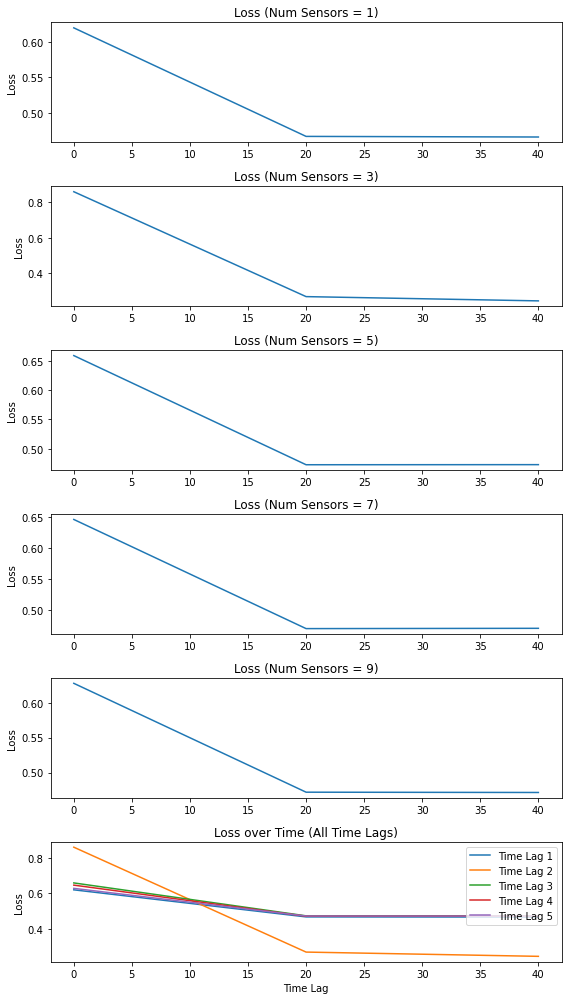

In [45]:
# plot results
# Creating subplots
fig, axs = plt.subplots(6, 1, figsize=(8, 14))
time_lag_values = np.array(range(13)) * 20

# Plotting loss over time for each time lag configuration
axs[0].plot(time_lag_values[0:3], validation_errors_sensors[0])
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss (Num Sensors = 1)')

axs[1].plot(time_lag_values[0:3], validation_errors[0:3])
axs[1].set_ylabel('Loss')
axs[1].set_title('Loss (Num Sensors = 3)')

axs[2].plot(time_lag_values[0:3], validation_errors_sensors[1])
axs[2].set_ylabel('Loss')
axs[2].set_title('Loss (Num Sensors = 5)')

axs[3].plot(time_lag_values[0:3], validation_errors_sensors[2])
axs[3].set_ylabel('Loss')
axs[3].set_title('Loss (Num Sensors = 7)')

axs[4].plot(time_lag_values[0:3], validation_errors_sensors[3])
axs[4].set_ylabel('Loss')
axs[4].set_title('Loss (Num Sensors = 9)')

# Plotting all loss values together
axs[5].plot(time_lag_values[0:3], validation_errors_sensors[0], label='Time Lag 1')
axs[5].plot(time_lag_values[0:3], validation_errors[0:3], label='Time Lag 2')
axs[5].plot(time_lag_values[0:3], validation_errors_sensors[1], label='Time Lag 3')
axs[5].plot(time_lag_values[0:3], validation_errors_sensors[2], label='Time Lag 4')
axs[5].plot(time_lag_values[0:3], validation_errors_sensors[3], label='Time Lag 5')
axs[5].set_xlabel('Time Lag')
axs[5].set_ylabel('Loss')
axs[5].set_title('Loss over Time (All Time Lags)')
axs[5].legend()

plt.tight_layout()

# Display the subplots
plt.show()